In [1]:
import warnings
warnings.filterwarnings('ignore') # Aren't I the checky git

In [2]:
import matplotlib.pyplot as plt
import pandas            as pds
import seaborn           as sns
import numpy             as np
import nltk
import statistics
import scipy

from datetime                import datetime
from sklearn.metrics         import classification_report as cr 
from sklearn.metrics         import r2_score as r2
from sklearn.metrics         import accuracy_score as ac 
from sklearn.metrics         import mean_squared_error as mse
from sklearn.metrics         import confusion_matrix as cm
from sklearn.model_selection import train_test_split as tts
from nltk.corpus             import wordnet          as wn
from nltk.corpus.reader.wordnet import WordNetError
from matplotlib.colors       import LogNorm

from sklearn.naive_bayes     import GaussianNB                 as GNB
from sklearn.naive_bayes     import MultinomialNB              as MNB
from sklearn.ensemble        import GradientBoostingClassifier as GBC 
from sklearn.ensemble        import RandomForestClassifier     as RFC
from sklearn.svm             import SVC                        as SVC
from sklearn.neighbors       import KNeighborsClassifier       as KNC
from sklearn.linear_model    import LogisticRegression         as LRE
from sklearn.linear_model    import LogisticRegressionCV       as LRC
from sklearn.mixture         import GaussianMixture            as GM
from sklearn.naive_bayes     import BernoulliNB                as BNB

In [175]:
df = pds.read_csv('insight-full.csv', header=0)
incoming_size = len(df)
df = df[(df['transport_code'].isnull()==False)  & (df['disp_problem_lvl'].isnull()==False) & 
        (df['latitude'].isnull()==False)        & (df['longitude'].isnull()==False) &
        (df['trans_score_mod'].isnull()==False) & (df['treat_score_mod'].isnull()==False) &
        (df['disp_problem_lvl']!='UNKNOWN')     & (df['age_yrs'].isnull()==False) &
        (df['sex'].isnull()==False)             & (df['sex']!='U') & (df['age_yrs']>0) &
        (df['disp_determinant/medical_code'].isnull()==False) &
        (df['disp_determinant/medical_code']!='XXXXX')]
df = df[(df['incidentcount'].isnull()==False) & (df['onscene_time'].isnull()==False)]
df = df[df['age_yrs'] < 105]
df.index = range(len(df))
outgoing_size = len(df)
print('Read in {0} events, working with {1} events.'.format(incoming_size, outgoing_size))
print('{} cut events'.format(incoming_size-outgoing_size))

Read in 342940 events, working with 311697 events.
31243 cut events


In [176]:
# print(df['transport_code'].unique())

# Choosing problems to work on

Only going to work on the biggest dispatch code to begin with.  I think this makes more sense than trying to do everything together.

In [177]:
code_list = list(df['disp_determinant/medical_code'].unique())
code_dict = {}
for i in range(len(code_list)):
    code_dict[code_list[i]] = i

In [178]:
for code in code_list:
    if len(df['disp_determinant/medical_code'][df['disp_determinant/medical_code']==code]) > 10000:
        print(code)

31D03
06D02
26D01
17B01
29B04


#### Let's pull out every time this situation comes up, no matter the response level

In [7]:
df['event'] = [x[:2]+x[3:] for x in df['disp_determinant/medical_code']]

#### Then serialize the response level part of the code

In [8]:
df['disp_level_code'] = 0
df['disp_level_code'] = [x[2] for x in df['disp_determinant/medical_code']]

In [9]:
# df['disp_level_code'].unique()

In [10]:
df['A'] = 0; df['A'][df['disp_level_code']=='A'] = 1
df['B'] = 0; df['B'][df['disp_level_code']=='B'] = 1
df['C'] = 0; df['C'][df['disp_level_code']=='C'] = 1
df['D'] = 0; df['D'][df['disp_level_code']=='D'] = 1
df['E'] = 0; df['E'][df['disp_level_code']=='E'] = 1
df['O'] = 0; df['O'][df['disp_level_code']=='O'] = 1

#### Creating a df for each of these so they don't get confused

In [11]:
# df_3103 = df[df['event']=='3103']
# df_0602 = df[df['event']=='0602']
df = df[df['event']=='2601']
df.index = range(len(df))
# df_1701 = df[df['event']=='1701']
# df_2904 = df[df['event']=='2904']

#### We now have 5 types of incidents to look at

# 1 Developing Classifications

How do we rate things as emergency or not?


A level 10 transport code is an acute trama and needs the full response.  These should correspond to L1 response from the dispatcher

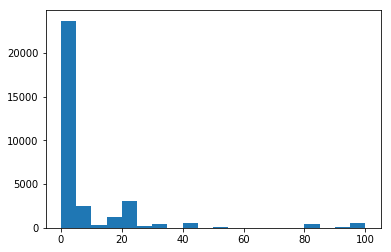

In [12]:
plt.hist(df['trans_score_mod'],bins=20)
plt.show()

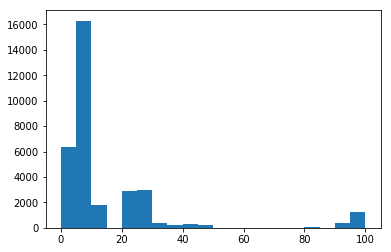

In [13]:
plt.hist(df['treat_score_mod'],bins=20)
plt.show()

#### Classification from documentation
According to the document I was given classification should be:

Low:  treat: 0 - 20,     trans: 0 - 12

Med:  treat: 20 - 92.5,  trans: 12 - 90

High: treat: 92.5 - 100, trans: 90 - 100

The final classification is determined by the highest catagory

In [14]:
df['class'] = 0

df['class'][(df['treat_score_mod'] > 92.4) | (df['trans_score_mod'] > 89.9) | 
            (df['transport_code'] == 10)] = 'L1'
df['class'][(df['treat_score_mod'] < 20)   & (df['trans_score_mod'] < 12)]   = 'L4'
df['class'][df['class']==0] = 'L3'

In [15]:
temp = pds.get_dummies(df['class'])
df = pds.concat([df,temp],axis=1)
# print(df['L3'])

In [16]:
# df[['class','trans_score_mod','treat_score_mod']].head(15)

#### Classifications:

High = L1

Medium = L3

Low = L4

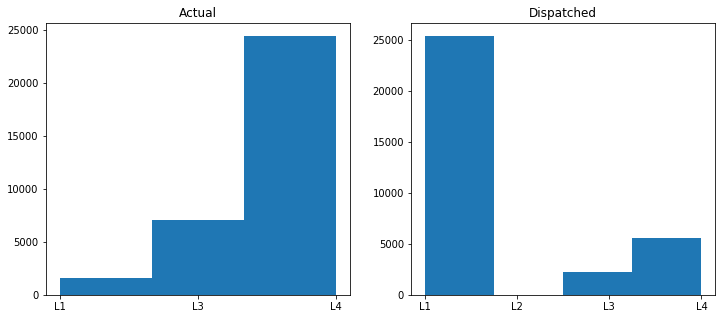

In [17]:
plt.figure(figsize=[12,5])
plt.subplot(1,2,1), plt.title('Actual')
plt.hist(df['class'],bins=3)
plt.subplot(1,2,2), plt.title('Dispatched')
plt.hist(df['disp_problem_lvl'],bins=4)
plt.show()

#### It might actually be simplier to look at this as Emergency / Non-Emergency without effecting the goals of the project at all.

In [18]:
df['class_b'] = df['class'].apply(lambda x: 1 if x=='L1' else 0)
df['disp_b']  = df['disp_problem_lvl'].apply(lambda x: 1 if x=='L1' else 0)

# 2 Prepare Time Feature

Turn time of day into an float between 0 - 24 by the minute and bin into groups of 15 minutes.

In [19]:
temp0 = df['response_date'].apply(lambda x: x.replace('.000', ''))
temp0 = temp0.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
temp1 = temp0.apply(lambda x: x.time())
temp2 = temp0.apply(lambda x: x.weekday())
# temp3 = temp0.apply(lambda x: x.month() )

temp2 = ['Monday' if x==0 else 'Tuesday'  if x==1 else 'Wednesday' if x==2 else 'Thursday' if x==3 else
         'Friday' if x==4 else 'Saturday' if x==5 else 'Sunday' for x in temp2]

df['response_time'] = temp0.apply(lambda x: x.hour+x.minute/60.)
temp2 = pds.get_dummies(temp2)
df    = pds.concat([df,temp2],axis=1)
# df['Monday'].head(5)

Time is in float types, need to bin the data.

In [20]:
df['response_time'] = df['response_time'].apply(lambda x: int(x*2)/2.)

#### Time is formatted.  Decided not to bin

# 3 Preparing sex

Need to change sex from M/F to 0/1

In [21]:
df['gender']                 = 0
df['gender'][df['sex']=='F'] = 1
df['gender'][df['sex']=='M'] = 0
# df['gender'][df['sex']=='M'].head(5)

#### Nothing could be simpler

# 4 Frequency of calls

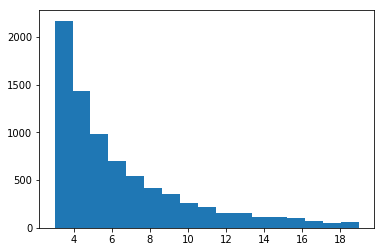

In [22]:
plt.figure()
plt.subplot()
# plt.yscale('log')0
plt.hist(df[(df['incidentcount']>2) & (df['incidentcount']<20)].\
         groupby('mpi_id')['incidentcount'].mean().values,bins=17)
# print(list(df.groupby('mpi_id')['incidentcount'].mean().values))
plt.show()

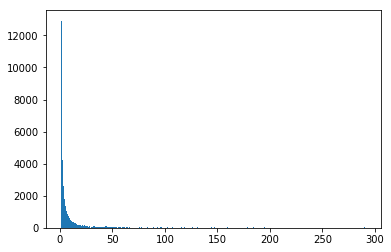

In [23]:
plt.hist(df['incidentcount'],bins=300)
plt.show()

In [24]:
temp = ['low_use' if x < 2 else 'med_use' if x < 20 else 'high_use' for x in df['incidentcount']]
temp = pds.get_dummies(temp)
df = pds.concat([df, temp], axis=1)

#### Let's go ahead and use this as well.

# 5 Response time
Maybe how long the ambulance takes to reach the person could help inform the model as well

In [25]:
ti = df['response_date'].apply(lambda x: x.replace('.000', ''))
ti = ti.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
ti = ti.apply(lambda x: x.hour+x.minute/60.+x.second/3600)

tf = df['onscene_time'].apply(lambda x: x.replace('.000', ''))
tf = tf.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
tf = tf.apply(lambda x: x.hour+x.minute/60.+x.second/3600)

In [26]:
tt = tf-ti
tt[tt<0] = tt+24
df['delta_arrival'] = tt
# tt = tt.apply(lambda x: x.hour + x.minute/60 + x.seconds/3600)
# print(tt)

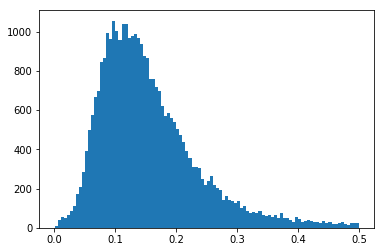

In [27]:
plt.hist(df['delta_arrival'][(df['delta_arrival']>0) & (df['delta_arrival']<.5)],bins=100)
plt.show()

#### Now we have how long it takes from the first call until arrival

# 6 Age

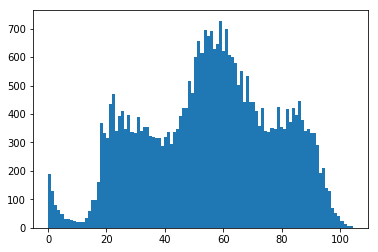

In [28]:
plt.hist(df['age_yrs'],bins=100)
plt.show()

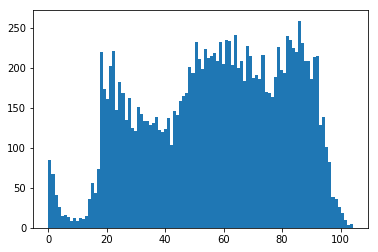

In [29]:
temp = df['age_yrs'][df['gender']==1]
plt.hist(temp,bins=100)
plt.show()

In [30]:
df['age_cat'] = ['child' if x < 10 else 'young' if x < 45 else 'middle' if x < 75 else 'old' for x in df['age_yrs']]

In [31]:
temp = pds.get_dummies(df['age_cat'])
# print(temp.head(5))
df = pds.concat([df, temp], axis=1)

In [32]:
# df['young'].head(5)

# 7 Text

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer as TFV
words_L1 = []; words_L3 = []; words_L4 = []
temp = df['disp_dispatch_comment'][df['class']=='L1'].values
for word in temp:
    tokens = nltk.word_tokenize(word)
    tagged = nltk.pos_tag(tokens)
    words_L1.append(tagged)
#     tfid_L1 = TFV().fit_transform(tokens)
    
temp = df['disp_dispatch_comment'][df['class']=='L3'].values
for word in temp:
    tokens = nltk.word_tokenize(word)
    tagged = nltk.pos_tag(tokens)
    words_L3.append(tagged)
#     tfid_L3 = TFV().fit_transform(tokens)

temp = df['disp_dispatch_comment'][df['class']=='L4'].values
for word in temp:
    tokens = nltk.word_tokenize(word)
    tagged = nltk.pos_tag(tokens)
    words_L4.append(tagged)
#     tfid_L4 = TFV().fit_transform(tokens)

In [ ]:
unique_L1   = {}
top_word_L1 = {}
for sentence in words_L1:
    for word in sentence:
        if 'VB' == word[1] or 'JJ' == word[1] or 'NN' == word[1] or 'RB' == word[1]:
            if word[0] in unique_L1:
                unique_L1[word[0]] += 1
            else:
                unique_L1[word[0]] = 1
# print(unique_L1)
for word in unique_L1:
    if unique_L1[word] > 50:
        top_word_L1[word] = unique_L1[word]
print(top_word_L1)

In [ ]:
unique_L3   = {}
top_word_L3 = {}
for sentence in words_L3:
    for word in sentence:
        if 'VB' == word[1] or 'JJ' == word[1] or 'NN' == word[1] or 'RB' == word[1]:
            if word[0] in unique_L3:
                unique_L3[word[0]] += 1
            else:
                unique_L3[word[0]] = 1
# print(unique_L3)
for word in unique_L3:
    if unique_L3[word] > 200:
        top_word_L3[word] = unique_L3[word]
print(top_word_L3)

In [ ]:
unique_L1   = {}
top_word_L1 = {}
for sentence in words_L1:
    for word in sentence:
        if 'VB' == word[1] or 'JJ' == word[1] or 'NN' == word[1] or 'RB' == word[1]:
            if word[0] in unique_L1:
                unique_L1[word[0]] += 1
            else:
                unique_L1[word[0]] = 1
# print(unique_L1)
for word in unique_L1:
    if unique_L1[word] > 200:
        top_word_L1[word] = unique_L1[word]
print(top_word_L1)

In [ ]:
# nltk.download()
# nltk.help.upenn_tagset()

# 8 Medical Codes

In [ ]:
# pds.get_dummies(df["disp_determinant/medical_code"])

# 9 Defining regions for the problem

In [ ]:
plt.figure(figsize=[16,10])
plt.hist2d(df_region['latitude'],df_region['longitude'],bins=100, cmap='Greys')
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=[15,15])
plt.hist2d(df_region['latitude'],df_region['longitude'],bins=50, cmap='Greys', range=([[32.65,32.8],[-117.19,-117.13]]))
plt.show()

In [ ]:
model = GM(n_components=3)
df_region = train_2601[['latitude','longitude']]

In [ ]:
region = model.fit(df_region)
temp = pds.DataFrame(region.predict(df_region))
# print(temp[0])

In [ ]:
df_region = pds.concat([df_region,temp], axis=1)

In [ ]:
df_region = df_region.rename(columns={0:'region'})

In [ ]:
x_min = df_region['latitude'].min()
x_max = df_region['latitude'].max()
y_min = df_region['longitude'].min()
y_max = df_region['longitude'].max()

In [ ]:
x = np.linspace(x_min, x_max)
y = np.linspace(y_min, y_max)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -region.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure(figsize=[15,15])
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.linspace(0,8,num=10), colors = 'red')
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.hist2d(df_region['latitude'], df_region['longitude'], bins=300, cmax=2)

plt.title('Negative log-likelihood predicted by a GMM')
# plt.axis('tight')
plt.show()

In [ ]:
plt.figure(figsize=[12,12])
plt.scatter(df_region['latitude'][df_region['region']==0], df_region['longitude'][df_region['region']==0])
plt.scatter(df_region['latitude'][df_region['region']==1], df_region['longitude'][df_region['region']==1])
plt.scatter(df_region['latitude'][df_region['region']==2], df_region['longitude'][df_region['region']==2])
plt.show()

# What do I have?
gender

age_yrs, child, young, middle, old

A B C D E O

delta_arrival

response_time

Monday Tuesday Wenesday Thursday Friday Saturday Sunday

incidentcount, low_use, med_use, high_use

class, class_b

#### These will be examined for specific events (types of injuries)

# Let's get ready

In [33]:
# print(len(df_3103))
# print(len(df_0602))
print(len(df))
# print(len(df_1701))
# print(len(df_2904))

33091


In [34]:
# train_0602, test_0602 = tts(df_0602, test_size=0.2)
# train_1701, test_1701 = tts(df_1701, test_size=0.2)
train_2601, test_2601 = tts(df, test_size=0.2)
# train_2904, test_2904 = tts(df_2904, test_size=0.2)
# train_3103, test_3103 = tts(df_3103, test_size=0.2)
# train, test = tts(df_2601, test_size=0.2)

In [ ]:
df['h']

# What does the data look like?

In [88]:
varis = ['response_time', 'child', 'young', 'old', 'middle', 'gender', 'class', 
         'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'sdpd_count', 'high_use', 'med_use', 'low_use',
         'Friday', 'Saturday', 'Sunday','A','B','C','D','incidentcount', 'delta_arrival','class_b']

In [ ]:
# print(train_0602[temp].groupby('class').mean())
# print(train_0602[temp].groupby('class').std())
# plt.hist(train_0602['class'],bins=3)
# plt.show()
# plt.hist(train_0602['disp_problem_lvl'],bins=3)
# plt.show()

# plt.figure(figsize=[20,20])
# corr = train_0602[temp].corr()
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

In [ ]:
# print(train_1701[temp].groupby('class').mean())
# # print(train_1701[temp].groupby('class').std())
# plt.hist(train_1701['class'],bins=3)
# plt.show()
# plt.hist(train_1701['disp_problem_lvl'],bins=3)
# plt.show()

# plt.figure(figsize=[20,20])
# corr = train_1701[temp].corr()
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

       response_time     child     young       old    middle    gender  \
class                                                                    
L1         13.157230  0.017598  0.208110  0.297628  0.476664  0.406274   
L3         13.228536  0.005166  0.205558  0.335768  0.453509  0.455468   
L4         12.831850  0.022863  0.323973  0.175490  0.477674  0.437164   

         Monday   Tuesday  Wednesday  Thursday   ...       Friday  Saturday  \
class                                            ...                          
L1     0.149197  0.138485   0.134660  0.139250   ...     0.159143  0.133894   
L3     0.157463  0.153545   0.146242  0.139829   ...     0.132882  0.136801   
L4     0.150529  0.149148   0.146898  0.135543   ...     0.137691  0.139226   

         Sunday         A         B         C         D  incidentcount  \
class                                                                    
L1     0.145371  0.085692  0.128539  0.196634  0.589135       4.834736   
L3     0.13

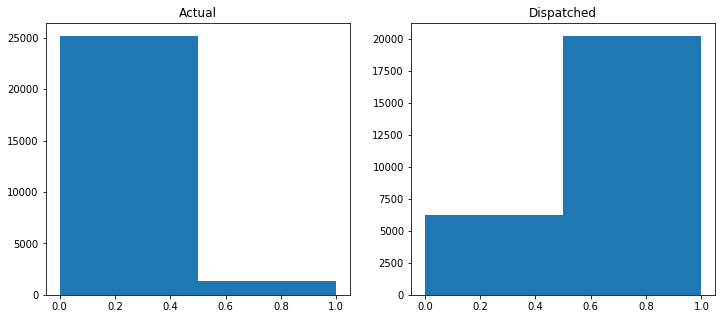

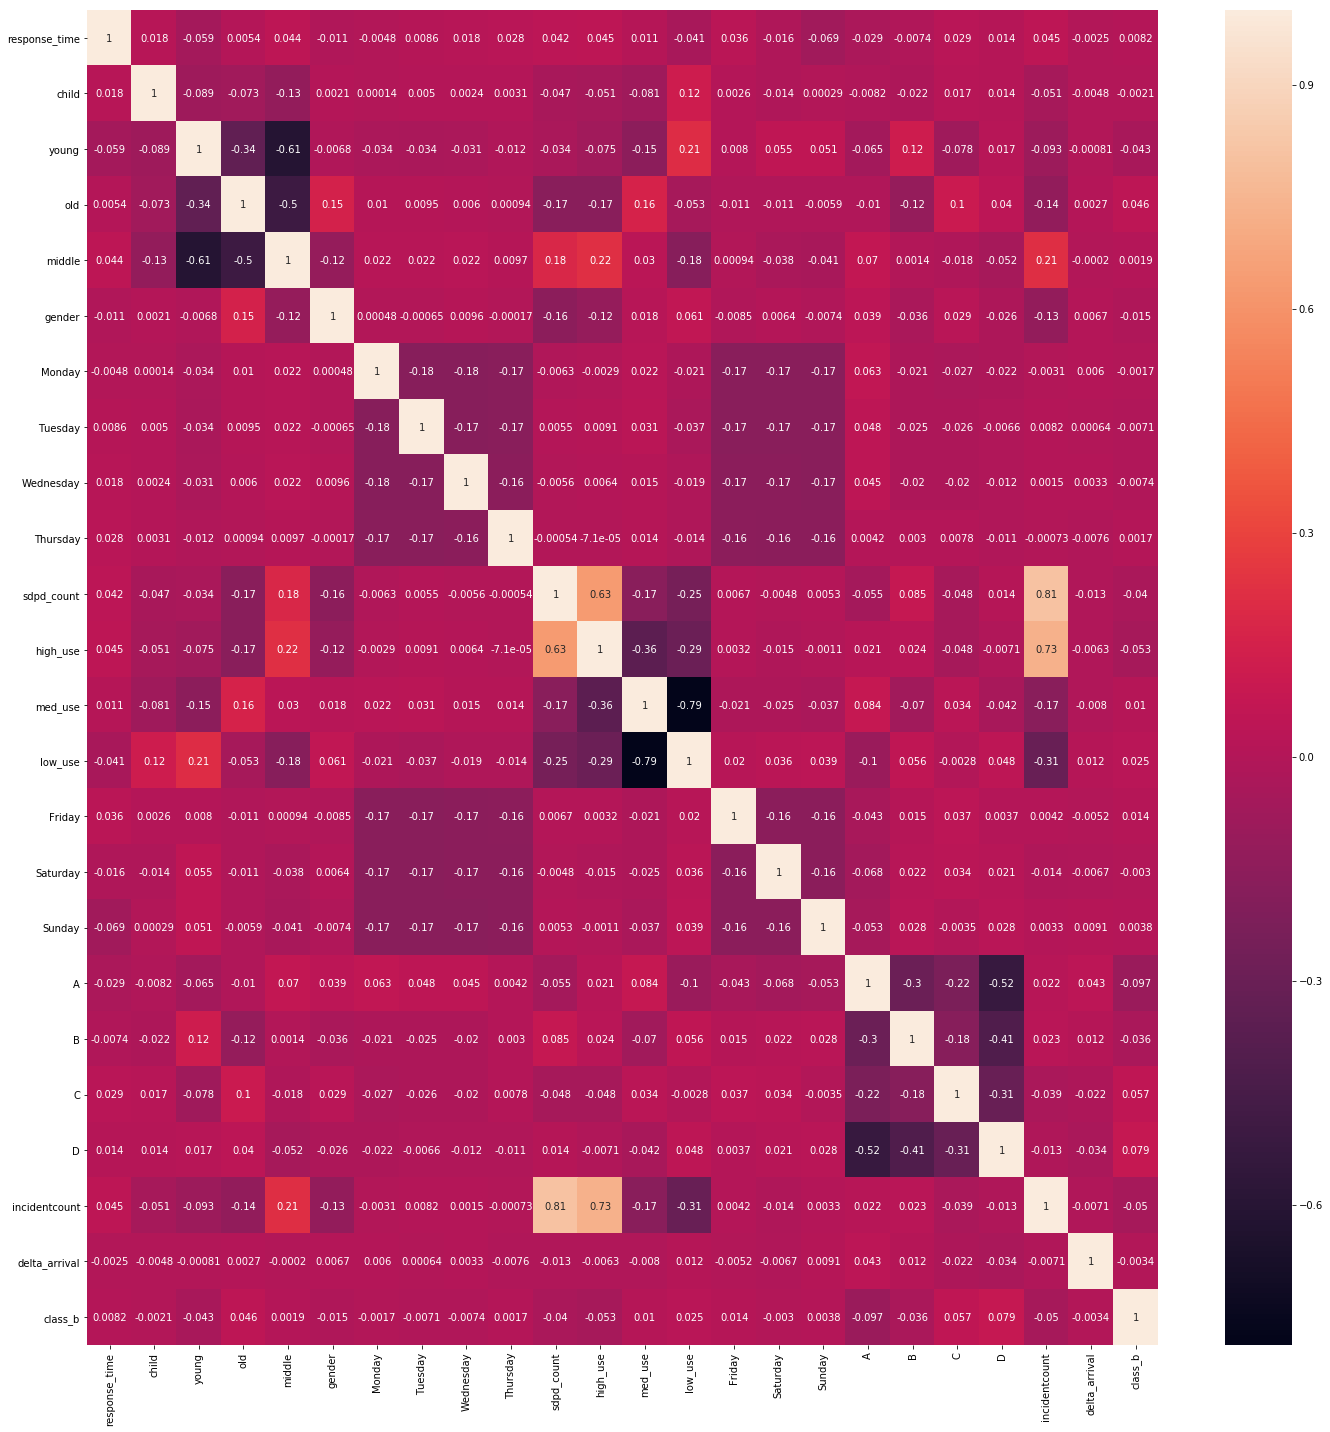

In [89]:
print(train_2601[varis].groupby('class').mean())
print(len(train_2601))
# print(train_2601[varis].groupby('class').std())
plt.figure(figsize=[12,5])
plt.subplot(1,2,1), plt.title('Actual')
plt.hist(train_2601['class_b'],bins=2)
plt.subplot(1,2,2), plt.title('Dispatched')
plt.hist(train_2601['disp_b'],bins=2)
plt.show()

plt.figure(figsize=[20,20])
corr = train_2601[varis].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# print(train_2904[temp].groupby('class').mean())
# # print(train_2904[temp].groupby('class').std())
# plt.hist(train_2904['class'],bins=3)
# plt.show()
# plt.hist(train_2904['disp_problem_lvl'],bins=3)
# plt.show()

# plt.figure(figsize=[20,20])
# corr = train_2904[temp].corr()
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

In [ ]:
# print(train_3103[temp].groupby('class').mean())
# # print(train_3103[temp].groupby('class').std())
# plt.hist(train_3103['class'],bins=3)
# plt.show()
# plt.hist(train_3103['disp_problem_lvl'],bins=3)
# plt.show()

# plt.figure(figsize=[20,20])
# corr = train_3103[temp].corr()
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

# 2601 model training

In [164]:
features = ['response_time', #'child', 'young', 'old', 'middle', 'gender',
         'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
         'sdpd_count', 'low_use', 'med_use', 'high_use', 'gender',
         'A','B','C','D', 'O', 'delta_arrival']
# features = ['response_time', 'age_yrs','incidentcount','delta_arrival','gender',
#            'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [165]:
df_train_slice = train_2601[train_2601['young']==1]
df_test_slice  = test_2601[test_2601['young']==1]
# print(len(df_train_slice['homeless'][df_train_slice['homeless'].isnull()]))
# print(len(df_train_slice))

In [166]:
model = GNB()
GNB_2601_model = model.fit(df_train_slice[features], df_train_slice['class_b'])
GNB_2601_prob  = model.predict_proba(df_test_slice[features])

In [167]:
model = BNB()
BNB_2601_model = model.fit(df_train_slice[features], df_train_slice['class_b'])
BNB_2601_prob  = model.predict_proba(df_test_slice[features])

In [168]:
model = LRE(class_weight='balanced', multi_class='multinomial', solver='saga')
LRE_2601_model = model.fit(df_train_slice[features], df_train_slice['class_b'])
LRE_2601_prob  = model.predict_proba(df_test_slice[features])
LRE_2601_pred  = model.predict(df_test_slice[features])

In [169]:
model = RFC()
RFC_2601_model = model.fit(df_train_slice[features], df_train_slice['class_b'])
RFC_2601_prob  = model.predict_proba(df_test_slice[features])

In [170]:
model = GBC()
GBC_2601_model = model.fit(df_train_slice[features], df_train_slice['class_b'])
GBC_2601_prob  = model.predict_proba(df_test_slice[features])

In [171]:
model = MNB()
MNB_2601_model = model.fit(df_train_slice[features], df_train_slice['class_b'])
MNB_2601_prob  = model.predict_proba(df_test_slice[features])

In [172]:
model = LRC()
LRC_2601_model = model.fit(df_train_slice[features], df_train_slice['class_b'])
LRC_2601_prob  = model.predict_proba(df_test_slice[features])

# 2601 testing models

[[1335  505]
 [  47   18]] 

[[ 366 1474]
 [   4   61]] 

Number of over responses predicted: 505
Number of over responses assigned:  1474
L1 responses correctly predicted:   27.69%
L1 responses correctly assigned:    93.85%


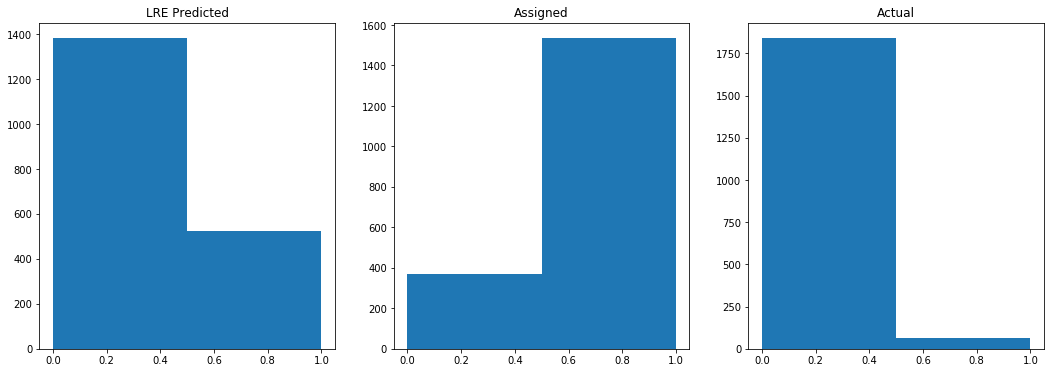

In [173]:
df_test_slice['LRE_pred'] = 0
# df_test_slice['LRE_pred'] = ['L1' if x[0] > 0.175 else 'L3' if x[1] > x[2] else 'L4' for x in LRE_2601_prob]
df_test_slice['LRE_pred'] = [0 if x[0] > 0.6 else 1 for x in LRE_2601_prob]

# print(df_test_slice['LRE_pred'][df_test_slice['class_b']==0])
cm1 = cm(df_test_slice['class_b'],df_test_slice['LRE_pred'])
cm2 = cm(df_test_slice['class_b'],df_test_slice['disp_b'])
print(cm1,'\n')
print(cm2,'\n')
temp0 = np.sum(cm1[0,1])
temp1 = np.sum(cm2[0,1])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[1,1]/np.sum(cm1[1])
temp1 = cm2[1,1]/np.sum(cm2[1])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(df_test_slice['LRE_pred'],bins=2)
plt.title('LRE Predicted')
plt.subplot(1,3,2)
plt.hist(df_test_slice['disp_b'],bins=2)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(df_test_slice['class_b'],bins=2)
plt.title('Actual')
plt.show()

X = np.array(train_2601[features].values)
y = np.array(train_2601['class_b'])
# print(X)
y = [1 if x == 'L1' else 0 for x in y]

# import statsmodels.api as sm
# from scipy import stats
# stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
# logit_model=sm.Logit(y, X)
# result=logit_model.fit()
# print(result.summary())

# p = np.array(df_test_slice[features].values)
# fuck_it = logit_model.predict(p[0])

# print(fuck_it)

[[ 552 1288]
 [  11   54]] 

[[ 366 1474]
 [   4   61]] 

Number of over responses predicted: 1288
Number of over responses assigned:  1474
L1 responses correctly predicted:   83.08%
L1 responses correctly assigned:    93.85%


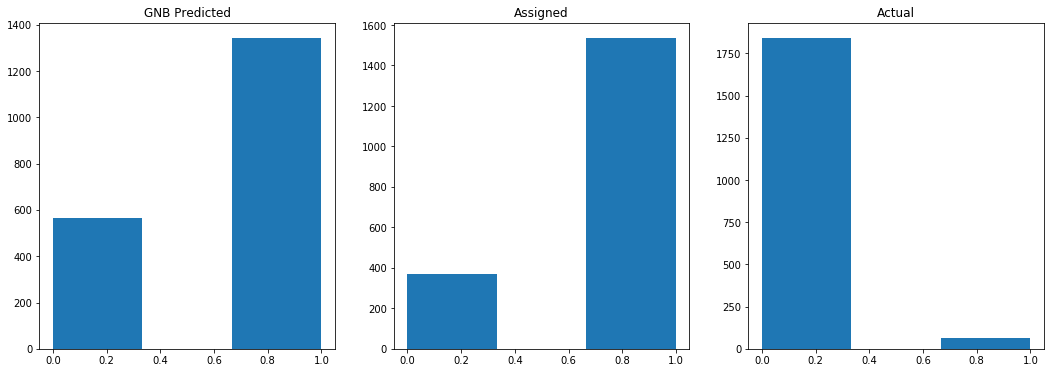

In [130]:
df_test_slice['GNB_pred'] = 0
# df_test_slice['GNB_pred'] = ['L1' if x[0] > 0.175 else 'L3' if x[1] > x[2] else 'L4' for x in GNB_2601_prob]
df_test_slice['GNB_pred'] = [0 if x[0] > 0.95 else 1 for x in GNB_2601_prob]

# print(df_test_slice['GNB_pred'][df_test_slice['class_b']==0])
cm1 = cm(df_test_slice['class_b'],df_test_slice['GNB_pred'])
cm2 = cm(df_test_slice['class_b'],df_test_slice['disp_b'])
print(cm1,'\n')
print(cm2,'\n')
temp0 = np.sum(cm1[0,1])
temp1 = np.sum(cm2[0,1])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[1,1]/np.sum(cm1[1])
temp1 = cm2[1,1]/np.sum(cm2[1])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(df_test_slice['GNB_pred'],bins=3)
plt.title('GNB Predicted')
plt.subplot(1,3,2)
plt.hist(df_test_slice['disp_b'],bins=3)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(df_test_slice['class_b'],bins=3)
plt.title('Actual')
plt.show()

X = np.array(train_2601[features].values)
y = np.array(train_2601['class_b'])
# print(X)
y = [1 if x == 'L1' else 0 for x in y]

# import statsmodels.api as sm
# from scipy import stats
# stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
# logit_model=sm.Logit(y, X)
# result=logit_model.fit()
# print(result.summary())

# p = np.array(df_test_slice[features].values)
# fuck_it = logit_model.predict(p[0])

# print(fuck_it)

[[1840    0]
 [  65    0]] 

[[ 366 1474]
 [   4   61]] 

Number of over responses predicted: 0
Number of over responses assigned:  1474
L1 responses correctly predicted:   0.00%
L1 responses correctly assigned:    93.85%


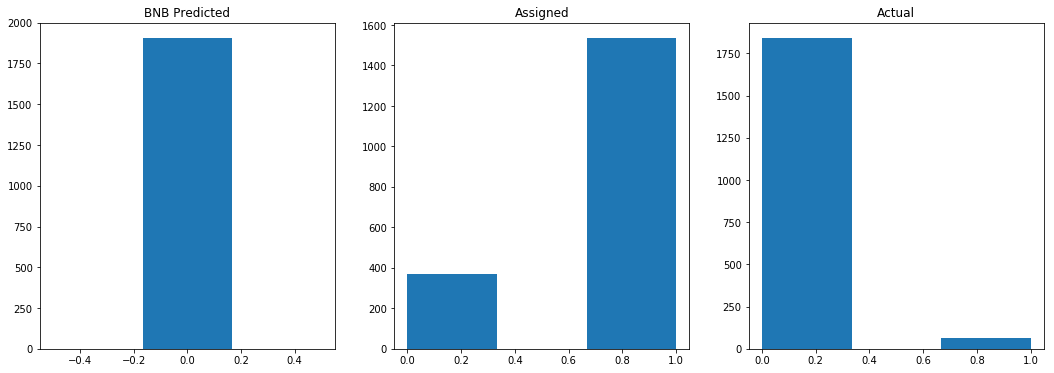

In [131]:
df_test_slice['BNB_pred'] = 0
# df_test_slice['BNB_pred'] = ['L1' if x[0] > 0.175 else 'L3' if x[1] > x[2] else 'L4' for x in BNB_2601_prob]
df_test_slice['BNB_pred'] = [0 if x[0] > 0.8 else 1 for x in BNB_2601_prob]

# print(df_test_slice['BNB_pred'][df_test_slice['class_b']==0])
cm1 = cm(df_test_slice['class_b'],df_test_slice['BNB_pred'])
cm2 = cm(df_test_slice['class_b'],df_test_slice['disp_b'])
print(cm1,'\n')
print(cm2,'\n')
temp0 = np.sum(cm1[0,1])
temp1 = np.sum(cm2[0,1])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[1,1]/np.sum(cm1[1])
temp1 = cm2[1,1]/np.sum(cm2[1])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(df_test_slice['BNB_pred'],bins=3)
plt.title('BNB Predicted')
plt.subplot(1,3,2)
plt.hist(df_test_slice['disp_b'],bins=3)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(df_test_slice['class_b'],bins=3)
plt.title('Actual')
plt.show()

X = np.array(train_2601[features].values)
y = np.array(train_2601['class_b'])
# print(X)
y = [1 if x == 'L1' else 0 for x in y]

# import statsmodels.api as sm
# from scipy import stats
# stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
# logit_model=sm.Logit(y, X)
# result=logit_model.fit()
# print(result.summary())

# p = np.array(df_test_slice[features].values)
# fuck_it = logit_model.predict(p[0])

# print(fuck_it)

[[1470  370]
 [  43   22]] 

[[ 366 1474]
 [   4   61]] 

Number of over responses predicted: 370
Number of over responses assigned:  1474
L1 responses correctly predicted:   33.85%
L1 responses correctly assigned:    93.85%


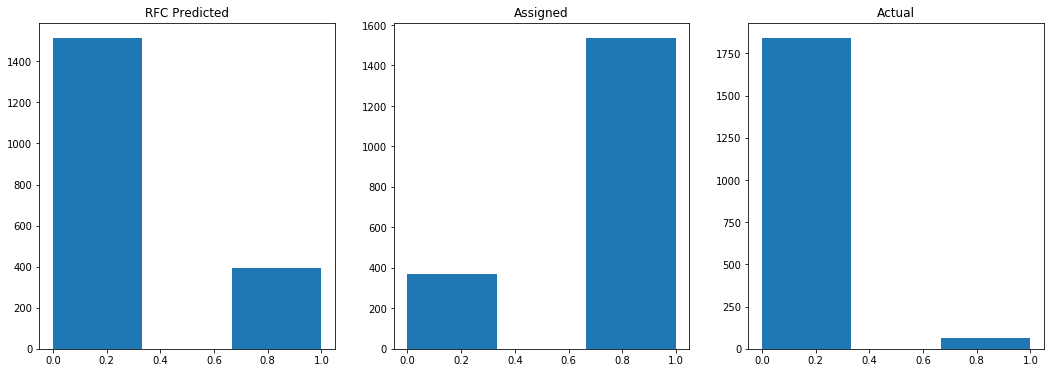

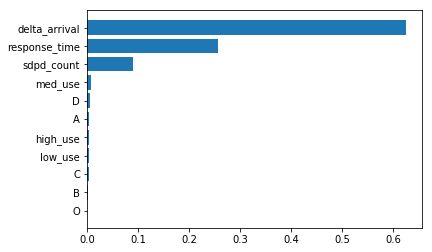

In [132]:
df_test_slice['RFC_pred'] = 0
# df_test_slice['RFC_pred'] = ['L1' if x[0] > 0.175 else 'L3' if x[1] > x[2] else 'L4' for x in RFC_2601_prob]
df_test_slice['RFC_pred'] = [0 if x[0] > 0.95 else 1 for x in RFC_2601_prob]

# print(df_test_slice['RFC_pred'][df_test_slice['class_b']==0])
cm1 = cm(df_test_slice['class_b'],df_test_slice['RFC_pred'])
cm2 = cm(df_test_slice['class_b'],df_test_slice['disp_b'])
print(cm1,'\n')
print(cm2,'\n')
temp0 = np.sum(cm1[0,1])
temp1 = np.sum(cm2[0,1])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[1,1]/np.sum(cm1[1])
temp1 = cm2[1,1]/np.sum(cm2[1])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(df_test_slice['RFC_pred'],bins=3)
plt.title('RFC Predicted')
plt.subplot(1,3,2)
plt.hist(df_test_slice['disp_b'],bins=3)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(df_test_slice['class_b'],bins=3)
plt.title('Actual')
plt.show()

X = np.array(train_2601[features].values)
y = np.array(train_2601['class_b'])
# print(X)
y = [1 if x == 'L1' else 0 for x in y]

# import statsmodels.api as sm
# from scipy import stats
# stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
# logit_model=sm.Logit(y, X)
# result=logit_model.fit()
# print(result.summary())

# p = np.array(df_test_slice[features].values)
# fuck_it = logit_model.predict(p[0])

# print(fuck_it)

feature_importance = RFC_2601_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_test_slice[features].columns[sorted_idx])
plt.show()

[[1840    0]
 [  65    0]] 

[[ 366 1474]
 [   4   61]] 

Number of over responses predicted: 0
Number of over responses assigned:  1474
L1 responses correctly predicted:   0.00%
L1 responses correctly assigned:    93.85%


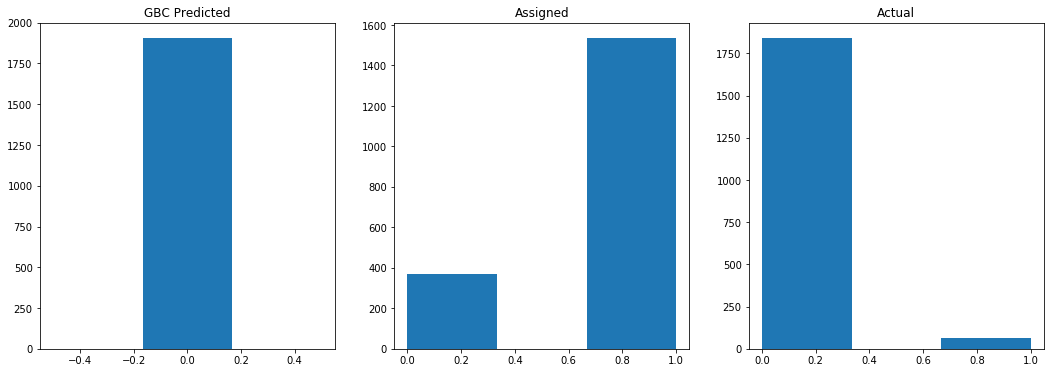

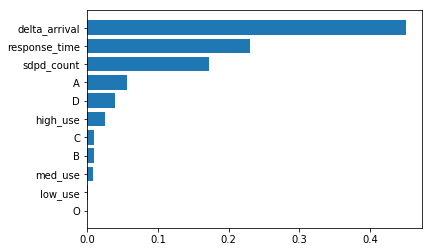

In [136]:
df_test_slice['GBC_pred'] = 0
# df_test_slice['GBC_pred'] = ['L1' if x[0] > 0.175 else 'L3' if x[1] > x[2] else 'L4' for x in GBC_2601_prob]
df_test_slice['GBC_pred'] = [0 if x[0] > 0.5 else 1 for x in GBC_2601_prob]

# print(df_test_slice['GBC_pred'][df_test_slice['class_b']==0])
cm1 = cm(df_test_slice['class_b'],df_test_slice['GBC_pred'])
cm2 = cm(df_test_slice['class_b'],df_test_slice['disp_b'])
print(cm1,'\n')
print(cm2,'\n')
temp0 = np.sum(cm1[0,1])
temp1 = np.sum(cm2[0,1])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[1,1]/np.sum(cm1[1])
temp1 = cm2[1,1]/np.sum(cm2[1])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(df_test_slice['GBC_pred'],bins=3)
plt.title('GBC Predicted')
plt.subplot(1,3,2)
plt.hist(df_test_slice['disp_b'],bins=3)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(df_test_slice['class_b'],bins=3)
plt.title('Actual')
plt.show()

X = np.array(train_2601[features].values)
y = np.array(train_2601['class_b'])
# print(X)
y = [1 if x == 'L1' else 0 for x in y]

# import statsmodels.api as sm
# from scipy import stats
# stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
# logit_model=sm.Logit(y, X)
# result=logit_model.fit()
# print(result.summary())

# p = np.array(df_test_slice[features].values)
# fuck_it = logit_model.predict(p[0])

# print(fuck_it)f

feature_importance = GBC_2601_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_test_slice[features].columns[sorted_idx])
plt.show()

[[1840    0]
 [  65    0]] 

[[ 366 1474]
 [   4   61]] 

Number of over responses predicted: 0
Number of over responses assigned:  1474
L1 responses correctly predicted:   0.00%
L1 responses correctly assigned:    93.85%


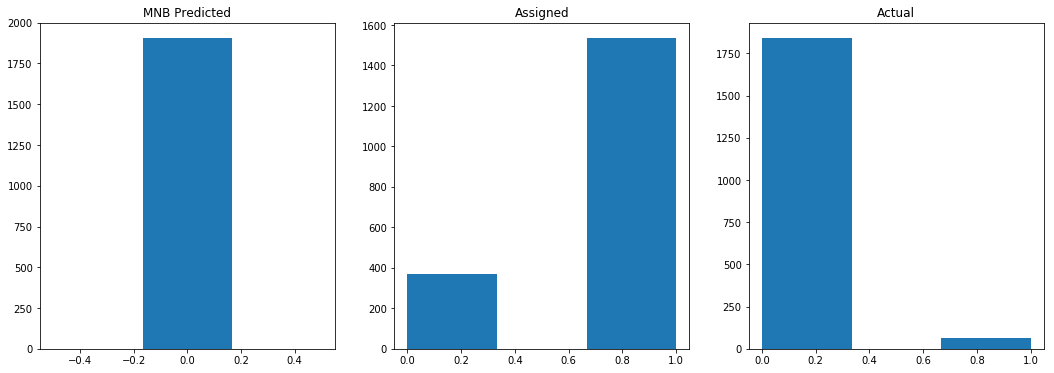

In [138]:
df_test_slice['MNB_pred'] = 0
# df_test_slice['MNB_pred'] = ['L1' if x[0] > 0.175 else 'L3' if x[1] > x[2] else 'L4' for x in MNB_2601_prob]
df_test_slice['MNB_pred'] = [0 if x[0] > 0.5 else 1 for x in MNB_2601_prob]

# print(df_test_slice['MNB_pred'][df_test_slice['class_b']==0])
cm1 = cm(df_test_slice['class_b'],df_test_slice['MNB_pred'])
cm2 = cm(df_test_slice['class_b'],df_test_slice['disp_b'])
print(cm1,'\n')
print(cm2,'\n')
temp0 = np.sum(cm1[0,1])
temp1 = np.sum(cm2[0,1])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[1,1]/np.sum(cm1[1])
temp1 = cm2[1,1]/np.sum(cm2[1])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(df_test_slice['MNB_pred'],bins=3)
plt.title('MNB Predicted')
plt.subplot(1,3,2)
plt.hist(df_test_slice['disp_b'],bins=3)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(df_test_slice['class_b'],bins=3)
plt.title('Actual')
plt.show()

X = np.array(train_2601[features].values)
y = np.array(train_2601['class_b'])
# print(X)
y = [1 if x == 'L1' else 0 for x in y]

[[1840    0]
 [  65    0]] 

[[ 366 1474]
 [   4   61]] 

Number of over responses predicted: 0
Number of over responses assigned:  1474
L1 responses correctly predicted:   0.00%
L1 responses correctly assigned:    93.85%


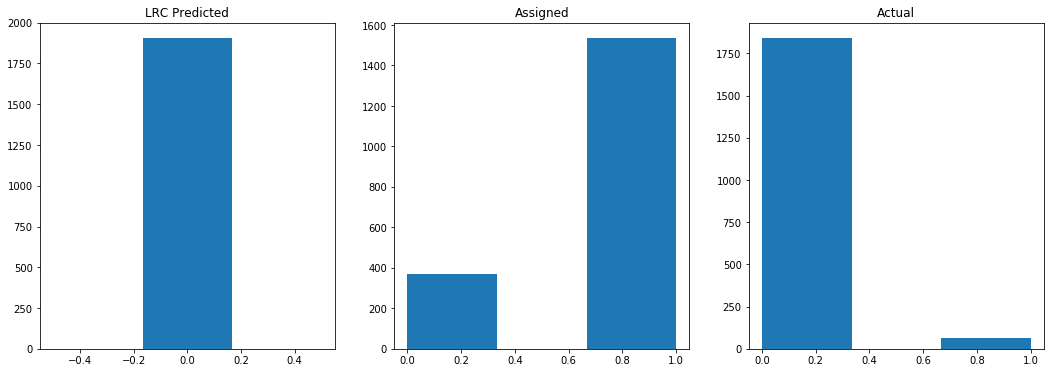

In [137]:
df_test_slice['LRC_pred'] = 0
# df_test_slice['LRC_pred'] = ['L1' if x[0] > 0.175 else 'L3' if x[1] > x[2] else 'L4' for x in LRC_2601_prob]
df_test_slice['LRC_pred'] = [0 if x[0] > 0.5 else 1 for x in LRC_2601_prob]

# print(df_test_slice['LRC_pred'][df_test_slice['class_b']==0])
cm1 = cm(df_test_slice['class_b'],df_test_slice['LRC_pred'])
cm2 = cm(df_test_slice['class_b'],df_test_slice['disp_b'])
print(cm1,'\n')
print(cm2,'\n')
temp0 = np.sum(cm1[0,1])
temp1 = np.sum(cm2[0,1])
print('Number of over responses predicted: {}'.format(temp0))
print('Number of over responses assigned:  {}'.format(temp1))
temp0 = cm1[1,1]/np.sum(cm1[1])
temp1 = cm2[1,1]/np.sum(cm2[1])
print('L1 responses correctly predicted:   {0:.2f}%'.format(temp0*100))
print('L1 responses correctly assigned:    {0:.2f}%'.format(temp1*100))
plt.figure(figsize=[18,6])
plt.subplot(1,3,1)
plt.hist(df_test_slice['LRC_pred'],bins=3)
plt.title('LRC Predicted')
plt.subplot(1,3,2)
plt.hist(df_test_slice['disp_b'],bins=3)
plt.title('Assigned')
plt.subplot(1,3,3)
plt.hist(df_test_slice['class_b'],bins=3)
plt.title('Actual')
plt.show()

X = np.array(train_2601[features].values)
y = np.array(train_2601['class_b'])
# print(X)
y = [1 if x == 'L1' else 0 for x in y]